In [1]:
# importing the necessary libraries

import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

import random

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score,f1_score, classification_report, confusion_matrix

import seaborn as sns

In [2]:
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [3]:
dataset_path = '/kaggle/input/images-jpmc/image dataset'
data_loader = load_images(dataset_path)

In [4]:
print(type(data_loader))
print(type(data_loader[0]))
print(data_loader[0].shape)

<class 'list'>
<class 'numpy.ndarray'>
(100, 100, 3)


In [5]:
def display_images(images, n, m):
    fig, axes = plt.subplots(n, m, figsize=(12, 12))
    
    for i in range(n):
        for j in range(m):
            axes[i][j].imshow(images[m * i + j], cmap='gray')
            axes[i][j].axis('off')

    plt.show()

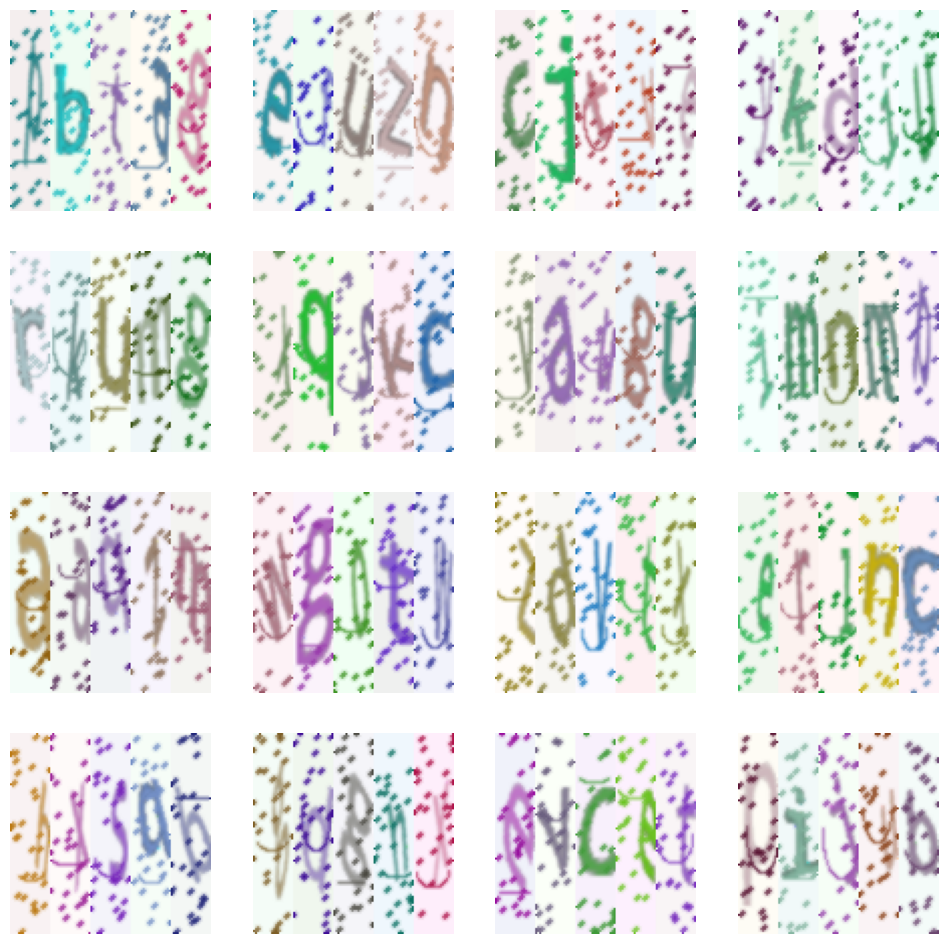

In [6]:
# display first few images

display_images(data_loader, 4, 4)

# IMAGE PREPROCESSING

In [7]:
def preprocess(data_loader):
    # creating a dictionary to store image as the key and corresponding alphabet as value
    image_dict = {}
    
    for filename, image in zip(os.listdir(dataset_path), data_loader):
#     for image in data_loader:
#         fig, axes = plt.subplots(2, 3, figsize=(8, 8))

        kernel = np.ones((2, 1), np.uint8)

        grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)    # shape=(100, 100)

        dilated1 = cv2.dilate(grayscale, kernel, iterations=7)
        eroded = cv2.erode(dilated1, kernel, iterations=2)
        dilated2 = cv2.dilate(eroded, kernel, iterations=2)
        
        laplacian = cv2.Laplacian(dilated2, cv2.CV_64F)
        
#         axes[0][0].imshow(image, cmap='gray')
#         axes[0][0].axis('off')

#         axes[0][1].imshow(grayscale, cmap='gray')
#         axes[0][1].axis('off')

#         axes[0][2].imshow(dilated1, cmap='gray')
#         axes[0][2].axis('off')
        
#         axes[1][0].imshow(eroded, cmap='gray')
#         axes[1][0].axis('off')
        
#         axes[1][1].imshow(dilated2, cmap='gray')
#         axes[1][1].axis('off')

#         axes[1][2].imshow(laplacian, cmap='gray')
#         axes[1][2].axis('off')
        
#         plt.tight_layout()

#         plt.show()
        
#         print(laplacian)
#         print(type(laplacian))
#         print(laplacian.dtype)
#         print(laplacian.shape)
        
        image_name = os.path.basename(filename)  # Get the image name without the folder path
        image_name = os.path.splitext(image_name)[0]  # Remove the file extension
        alphabet_list = list(image_name)  # Convert the image name to a list of alphabets
        
        for i in range(5):
            # Convert the laplacian image to a tuple of tuples
            # removing extra pixels from top and bottom
            # splitting images into 5 alphabets (20 pixels each)
            image_key = tuple(map(tuple, laplacian[20:80, 20 * i : 20 * (i + 1)]))  
            image_dict[image_key] = alphabet_list[i]  # Assign the Laplacian image as the key and the alphabet list as the value

    return image_dict

In [8]:
preprocessed_images = preprocess(data_loader)

In [9]:
# train - validation split

imgs = [[] for i in range(26)]

for image_key, alphabet in preprocessed_images.items():
    image = np.array(image_key)
    imgs[ord(alphabet) - ord('a')].append(image)
    
X_train = []
y_train = []
X_val = []
y_val = []

for i in range(26):
    random.shuffle(imgs[i])
    total_samples = len(imgs[i])
    train_ratio = 0.8
    train_samples = int(train_ratio * total_samples)
    
    X_train += imgs[i][:train_samples]
    y_train += [ chr(ord('a') + i)  for  j  in  range(train_samples) ]
    X_val += imgs[i][train_samples:]
    y_val += [ chr(ord('a') + i)  for  j  in  range(total_samples - train_samples) ]
    
# Print the train and validation set sizes
print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))

Train set size: 3993
Validation set size: 1007


In [10]:
# Shuffling the data

combined = list(zip(X_train, y_train))
random.shuffle(combined)
X_train, y_train = zip(*combined)

combined = list(zip(X_val, y_val))
random.shuffle(combined)
X_val, y_val = zip(*combined)

In [11]:
# reshaping the mulit-dimensional arrays into 1-dimensional arrays

X_train_flat = np.array([img.flatten() for img in X_train])
X_val_flat = np.array([img.flatten() for img in X_val])

# LOGISTIC REGRESSION

In [12]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_flat, y_train)

y_pred = lr.predict(X_val_flat)
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

y_train_pred = lr.predict(X_train_flat)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

f1 = f1_score(y_val, y_pred, average='weighted')
print("F1 Score:", f1)

Validation Accuracy: 0.2869910625620655
Training Accuracy: 1.0
F1 Score: 0.29011597563546


### GETTING THE PRECISION, RECALL AND F1-SCORE FOR ALL CHARACTERS FOR LOGISTIC REGRESSION

In [13]:
report_val = classification_report(y_val, y_pred)
print(report_val)

              precision    recall  f1-score   support

           a       0.29      0.22      0.25        41
           b       0.19      0.21      0.20        39
           c       0.17      0.12      0.14        40
           d       0.21      0.24      0.22        38
           e       0.42      0.46      0.44        39
           f       0.20      0.28      0.23        40
           g       0.54      0.39      0.45        36
           h       0.20      0.20      0.20        35
           i       0.36      0.29      0.32        35
           j       0.35      0.32      0.33        41
           k       0.34      0.35      0.35        37
           l       0.13      0.20      0.15        41
           m       0.16      0.12      0.14        42
           n       0.27      0.30      0.28        40
           o       0.25      0.34      0.29        38
           p       0.44      0.29      0.35        38
           q       0.50      0.35      0.41        37
           r       0.38    

## SVM

In [14]:
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_flat, y_train)

y_pred = svm.predict(X_val_flat)
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

y_train_pred = svm.predict(X_train_flat)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

f1 = f1_score(y_val, y_pred, average='weighted')
print("F1 Score:", f1)

Validation Accuracy: 0.35650446871896724
Training Accuracy: 1.0
F1 Score: 0.36118062285446795


In [15]:
svm = SVC(kernel='sigmoid', random_state=42)
svm.fit(X_train_flat, y_train)

y_pred = svm.predict(X_val_flat)
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

y_train_pred = svm.predict(X_train_flat)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy (SVM):", train_accuracy)

f1 = f1_score(y_val, y_pred, average='weighted')
print("F1 Score:", f1)

Validation Accuracy: 0.37636544190665344
Training Accuracy (SVM): 0.5414475331830704
F1 Score: 0.3748834181950009


In [16]:
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train_flat, y_train)

y_pred = svm.predict(X_val_flat)
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

y_train_pred = svm.predict(X_train_flat)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy (SVM):", train_accuracy)

f1 = f1_score(y_val, y_pred, average='weighted')
print("F1 Score:", f1)

Validation Accuracy: 0.5173783515392254
Training Accuracy (SVM): 0.9040821437515653
F1 Score: 0.5174710451976064


### GETTING THE PRECISION, RECALL AND F1-SCORE FOR ALL CHARACTERS FOR SVM WITH rbf kernel

In [17]:
report_val = classification_report(y_val, y_pred)
print(report_val)

              precision    recall  f1-score   support

           a       0.47      0.49      0.48        41
           b       0.50      0.46      0.48        39
           c       0.62      0.33      0.43        40
           d       0.71      0.53      0.61        38
           e       0.50      0.59      0.54        39
           f       0.33      0.47      0.39        40
           g       0.57      0.78      0.66        36
           h       0.44      0.20      0.27        35
           i       0.76      0.46      0.57        35
           j       0.33      0.76      0.46        41
           k       0.86      0.32      0.47        37
           l       0.28      0.56      0.37        41
           m       0.58      0.60      0.59        42
           n       0.50      0.35      0.41        40
           o       0.53      0.66      0.59        38
           p       0.74      0.45      0.56        38
           q       0.79      0.59      0.68        37
           r       0.56    

# RANDOM FOREST

In [18]:
rf = RandomForestClassifier()
rf.fit(X_train_flat, y_train)

y_pred = rf.predict(X_val_flat)
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

y_train_pred = rf.predict(X_train_flat)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy (Random Forest):", train_accuracy)

f1 = f1_score(y_val, y_pred, average='weighted')
print("F1 Score:", f1)

Validation Accuracy: 0.6673286991062563
Training Accuracy (Random Forest): 1.0
F1 Score: 0.6644070299342514


### GETTING THE PRECISION, RECALL AND F1-SCORE FOR ALL CHARACTERS USING RANDOM FOREST

In [19]:
report_val = classification_report(y_val, y_pred)
print(report_val)

              precision    recall  f1-score   support

           a       0.67      0.90      0.77        41
           b       0.50      0.64      0.56        39
           c       0.81      0.75      0.78        40
           d       0.70      0.79      0.74        38
           e       0.71      0.56      0.63        39
           f       0.58      0.47      0.52        40
           g       0.88      0.64      0.74        36
           h       0.33      0.14      0.20        35
           i       0.64      0.60      0.62        35
           j       0.41      0.90      0.56        41
           k       0.79      0.59      0.68        37
           l       0.60      0.61      0.60        41
           m       0.80      0.86      0.83        42
           n       0.60      0.53      0.56        40
           o       0.60      0.84      0.70        38
           p       0.69      0.63      0.66        38
           q       0.82      0.76      0.79        37
           r       0.83    

In [20]:
rf = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_split=5, min_samples_leaf=3)

rf.fit(X_train_flat, y_train)

y_pred = rf.predict(X_val_flat)
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

y_train_pred = rf.predict(X_train_flat)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy (Random Forest):", train_accuracy)

f1 = f1_score(y_val, y_pred, average='weighted')
print("F1 Score:", f1)

Validation Accuracy: 0.6276067527308838
Training Accuracy (Random Forest): 0.9574254946155772
F1 Score: 0.628626663062386


In [21]:
report_val = classification_report(y_val, y_pred)
print(report_val)

              precision    recall  f1-score   support

           a       0.78      0.95      0.86        41
           b       0.53      0.64      0.58        39
           c       0.68      0.42      0.52        40
           d       0.78      0.76      0.77        38
           e       0.90      0.69      0.78        39
           f       0.58      0.35      0.44        40
           g       0.89      0.69      0.78        36
           h       0.42      0.23      0.30        35
           i       0.81      0.49      0.61        35
           j       0.32      0.98      0.48        41
           k       0.95      0.57      0.71        37
           l       0.39      0.41      0.40        41
           m       0.85      0.83      0.84        42
           n       0.48      0.30      0.37        40
           o       0.53      0.76      0.62        38
           p       0.79      0.61      0.69        38
           q       0.89      0.65      0.75        37
           r       0.82    

In [22]:
rf = RandomForestClassifier(n_estimators=500, max_depth=15, min_samples_split=5, min_samples_leaf=4)

rf.fit(X_train_flat, y_train)

y_pred = rf.predict(X_val_flat)
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

y_train_pred = rf.predict(X_train_flat)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy (Random Forest):", train_accuracy)

f1 = f1_score(y_val, y_pred, average='weighted')
print("F1 Score:", f1)

Validation Accuracy: 0.6782522343594836
Training Accuracy (Random Forest): 0.9989982469321312
F1 Score: 0.6790571813504636


In [23]:
report_val = classification_report(y_val, y_pred)
print(report_val)

              precision    recall  f1-score   support

           a       0.72      0.95      0.82        41
           b       0.60      0.67      0.63        39
           c       0.77      0.68      0.72        40
           d       0.75      0.79      0.77        38
           e       0.90      0.72      0.80        39
           f       0.64      0.45      0.53        40
           g       0.96      0.75      0.84        36
           h       0.50      0.26      0.34        35
           i       0.87      0.57      0.69        35
           j       0.38      0.95      0.54        41
           k       0.81      0.59      0.69        37
           l       0.49      0.59      0.53        41
           m       0.89      0.79      0.84        42
           n       0.55      0.42      0.48        40
           o       0.62      0.76      0.68        38
           p       0.77      0.61      0.68        38
           q       0.84      0.73      0.78        37
           r       0.86    

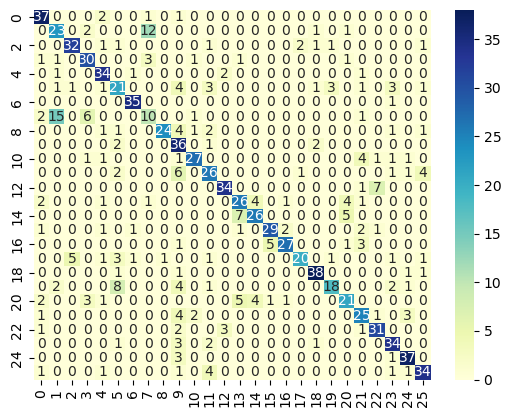

In [28]:
conf_val = confusion_matrix(y_true=y_val, y_pred=y_pred)

sns.heatmap(data=conf_val, annot=True, cmap='YlGnBu')
plt.show()

## META MODELS

In [25]:
# Define the base models
base_models = [('svm', SVC(kernel='rbf', random_state=42))]

# Define the meta model
meta_model = RandomForestClassifier(n_estimators=500, max_depth=15, min_samples_split=5, min_samples_leaf=4)

# Define the stacking regressor
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Train the model
stacked_model.fit(X_train_flat, y_train)

# Predict on the test set
y_pred = stacked_model.predict(X_val_flat)
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

y_train_pred = stacked_model.predict(X_train_flat)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy (Random Forest):", train_accuracy)

f1 = f1_score(y_val, y_pred, average='weighted')
print("F1 Score:", f1)

Validation Accuracy: 0.5094339622641509
Training Accuracy (Random Forest): 0.8950663661407463
F1 Score: 0.5055123386504026


In [26]:
# Define the base models
base_models = [('rf', RandomForestClassifier(n_estimators=250, max_depth=10, min_samples_split=5, min_samples_leaf=4))]

# Define the meta model
meta_model = SVC(kernel='rbf', random_state=42) 

# Define the stacking regressor
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Train the model
stacked_model.fit(X_train_flat, y_train)

# Predict on the test set
y_pred = stacked_model.predict(X_val_flat)
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

y_train_pred = stacked_model.predict(X_train_flat)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy (Random Forest):", train_accuracy)

f1 = f1_score(y_val, y_pred, average='weighted')
print("F1 Score:", f1)

Validation Accuracy: 0.6822244289970208
Training Accuracy (Random Forest): 0.9266215877786126
F1 Score: 0.6825992451845184


In [27]:
# Define the base models
base_models = [('rf', RandomForestClassifier(n_estimators=500, max_depth=15, min_samples_split=5, min_samples_leaf=4))]

# Define the meta model
meta_model = SVC(kernel='rbf', random_state=42) 

# Define the stacking regressor
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Train the model
stacked_model.fit(X_train_flat, y_train)

# Predict on the test set
y_pred = stacked_model.predict(X_val_flat)
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

y_train_pred = stacked_model.predict(X_train_flat)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy (Random Forest):", train_accuracy)

f1 = f1_score(y_val, y_pred, average='weighted')
print("F1 Score:", f1)

Validation Accuracy: 0.7298907646474677
Training Accuracy (Random Forest): 0.972702228900576
F1 Score: 0.7282293780185002


In [29]:
report_val = classification_report(y_val, y_pred)
print(report_val)

              precision    recall  f1-score   support

           a       0.77      0.90      0.83        41
           b       0.53      0.59      0.56        39
           c       0.84      0.80      0.82        40
           d       0.71      0.79      0.75        38
           e       0.76      0.87      0.81        39
           f       0.53      0.53      0.53        40
           g       0.92      0.97      0.95        36
           h       0.37      0.29      0.32        35
           i       0.96      0.69      0.80        35
           j       0.51      0.88      0.64        41
           k       0.84      0.73      0.78        37
           l       0.63      0.63      0.63        41
           m       0.87      0.81      0.84        42
           n       0.65      0.65      0.65        40
           o       0.76      0.68      0.72        38
           p       0.83      0.76      0.79        38
           q       0.87      0.73      0.79        37
           r       0.87    